In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
from wrn4 import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
seg_aug = pd.read_csv('../aug/augment.csv', header=None)
seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [3]:
len(seg),len(seg_aug), len(test_names)

(31072, 68093, 11702)

In [4]:
df = pd.merge(seg, seg_aug,'outer'); len(df)

99165

In [5]:
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
df_ = df.sample(5000)

In [7]:
class Decoder(nn.Module):
    '''simple decoder'''
    def __init__(self, ni=1024, blocks=7):
        super().__init__()
        layers = []
        for i in range(blocks):
#             print(ni//(2**i))
            layers.append(conv_layer(ni//(2**i), ni//(2**(i+1)), 
                                     ks=2, stride=2, transpose=True, norm_type=None))
#             layers.append(nn.Upsample(scale_factor=2))
        layers.append(conv_layer(ni//(2**(i+1)), 3,
                                 ks=2, stride=2, transpose=True, norm_type=None, 
                                 use_activ=False))
        layers.append(nn.Tanh())
        self.layers = nn.Sequential(*layers)

    def forward(self, x): return self.layers(x)

In [9]:
decoder = Decoder(256, 3); decoder

Decoder(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
      (1): ReLU(inplace)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): ReLU(inplace)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): ReLU(inplace)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
    )
    (4): Tanh()
  )
)

In [10]:
decoder(torch.rand(1, 256, 32, 32)).shape

torch.Size([1, 3, 512, 512])

In [11]:
encoder = Darknet([1,2,4,4,3], len(classes), nf=8, se=True, head=False);
encoder(torch.rand(1, 3, 512, 512)).shape

torch.Size([1, 256, 32, 32])

In [44]:
m = nn.Sequential(encoder, decoder); m(torch.rand(1, 3, 512, 512)).shape

torch.Size([1, 3, 512, 512])

In [45]:
pct = 0.1
sample = 5000
src = (ImageImageList.from_df(df=df_.sample(sample), path=PATH, folder=TRAIN_AUG, suffix='.png')
       .random_split_by_pct(pct, seed=42)
      )

In [46]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [47]:
def get_data(sz=64, bs=64):
    data = (src.label_from_func(lambda x: x)
            .transform(tfms, size=sz, tfms_y=True)
            .databunch(bs=bs).normalize(stats, do_y=True)
           )
    data.c = 3
    return data

In [48]:
data = get_data(64, 2)

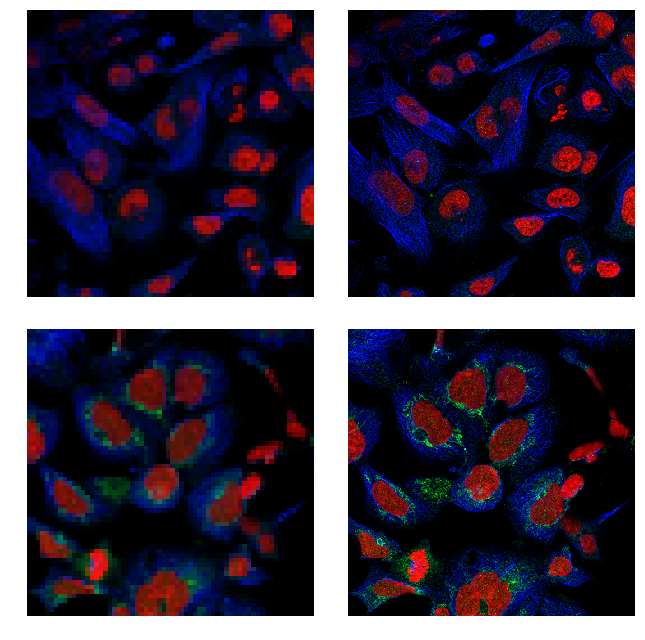

In [49]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [40]:
x,y = next(iter(data.train_dl))

In [41]:
x.shape, y.shape

(torch.Size([2, 3, 64, 64]), torch.Size([2, 3, 512, 512]))

In [19]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
    learn.split((arch.layers[11],arch.layers[20]))  #Split for 444 model [11,20]
    return learn.mixup(stack_y=False)

# 64

In [45]:
data = get_data(sz=64, bs=128, pct=0.05, sample=None)
learn = get_learner(data, focal=False, fp16=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


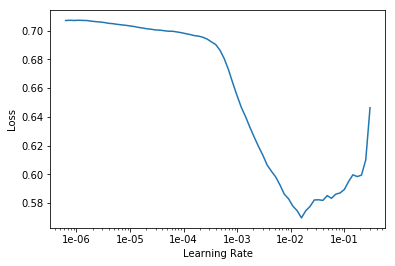

In [46]:
learn.lr_find()
learn.recorder.plot()

In [24]:
lr=1e-2

In [48]:
%time learn.fit_one_cycle(30, lr,wd=0.2, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.469936,0.341113,0.876190,0.131686
2,0.391317,0.321198,0.870748,0.110187
3,0.362358,0.292608,0.887755,0.111385
4,0.347249,0.359223,0.868027,0.081964
5,0.336764,0.375017,0.868027,0.040000
6,0.333914,0.373471,0.870748,0.044103
7,0.330600,0.352153,0.880952,0.065805
8,0.327777,0.297697,0.882313,0.059006
9,0.326353,0.302178,0.885034,0.130518
10,0.325668,0.368069,0.877551,0.089249


CPU times: user 4min 12s, sys: 2min 35s, total: 6min 48s
Wall time: 9min 32s


In [49]:
learn.save('dk3_low_64')

# 128

In [55]:
learn.data = get_data(sz=128, bs=64, pct=0.2, sample=None)

In [56]:
learn.load('dk3_low_64');

In [57]:
%time learn.fit_one_cycle(30, lr/3, wd=0.2, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.279522,0.260724,0.899154,0.208652
2,0.273480,0.256420,0.896785,0.226744
3,0.271247,0.255004,0.898308,0.242528
4,0.267138,0.249029,0.902707,0.257332
5,0.264381,0.259100,0.898139,0.255374
6,0.263477,0.257356,0.895770,0.233180
7,0.263138,0.263896,0.893909,0.231913
8,0.265460,0.267107,0.897631,0.248598
9,0.267400,0.285459,0.886125,0.284449
10,0.265056,0.273482,0.893909,0.234182


CPU times: user 13min 45s, sys: 8min 25s, total: 22min 11s
Wall time: 24min 34s


In [58]:
learn.save('dk3_low_128')

# 256

In [20]:
data = get_data(sz=256, bs=32, pct=0.1, sample=None)
learn = get_learner(data, focal=False, fp16=True)

In [21]:
learn.load('dk3_low_128');

In [22]:
learn.freeze()

In [25]:
%time learn.fit_one_cycle(10, slice(lr), wd=0.3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.235139,0.218454,0.908475,0.399139
2,0.238507,0.218190,0.908813,0.428811
3,0.231320,0.206089,0.914237,0.420927
4,0.228057,0.202573,0.921356,0.460241
5,0.226824,0.210637,0.920678,0.460185
6,0.227409,0.189745,0.923729,0.510606
7,0.217743,0.187781,0.922373,0.503374
8,0.218066,0.186549,0.921356,0.481176
9,0.215383,0.185299,0.924746,0.489853
10,0.210882,0.189327,0.920678,0.477719


CPU times: user 14min 30s, sys: 8min 3s, total: 22min 34s
Wall time: 23min 1s


In [26]:
learn.save('dk3_low_256');

In [27]:
learn.unfreeze()

In [28]:
%time learn.fit_one_cycle(10, slice(lr/10, lr/3), wd=0.3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.215144,0.182445,0.925763,0.501801
2,0.216636,0.214055,0.912881,0.440970
3,0.220701,0.188132,0.921695,0.401608
4,0.215301,0.207184,0.918644,0.475934
5,0.218456,0.198568,0.918644,0.496637
6,0.210368,0.179256,0.928814,0.508000
7,0.200855,0.182576,0.922373,0.436297
8,0.195623,0.180023,0.926780,0.516698
9,0.193309,0.165889,0.930170,0.492113
10,0.191314,0.165421,0.929492,0.516040


CPU times: user 17min 9s, sys: 10min 56s, total: 28min 5s
Wall time: 28min 30s


In [29]:
learn.save('dk3_low_256');

In [30]:
learn.load('dk3_low_256');
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

## 512

In [13]:
data = get_data(512, 8, 0.01, sample = None)  #training with 512 size does not work.
learn = get_learner(data, focal=True, fp16=True)

In [26]:
learn.load('dk3_444_se_256');

In [27]:
learn.freeze()

In [ ]:
%time learn.fit_one_cycle(1, slice(1e-3), wd=0.3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1


In [ ]:
learn.save('dk3_444_se_512');

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(1, slice(1e-5, 1e-3), div_factor=25, pct_start=0.3)

In [ ]:
learn.save('dk3_444_se_512_2');

# Validation and Preds

In [68]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

Total time: 1:25:22



In [45]:
p.shape

torch.Size([11702, 28])

Compute optimal THS

In [31]:
#train data preds
learn.data.valid_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds(ds_type=DatasetType.Valid)

In [32]:
p_v_s = p_v.sigmoid()
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [33]:
ths = find_thresh(p_v_np, t_v_np); ths

array([0.53, 0.63, 0.56, 0.68, 0.68, 0.61, 0.6 , 0.56, 0.67, 0.65])

In [34]:
len(ths)

10

In [37]:
f1_np(p_v_np, t_v_np, ths)

0.6614129357818596

# Sub File

In [38]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = ths
print(preds.shape)
classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 10)


In [39]:
classes

array(['16', '24', '20', '17', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [40]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [41]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,16
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,16
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,16 26
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,16
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,16
